# 1. Two-dimensional data
First we start by creating our nececarry inputs

In [3]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

Create three different sized datasets and save them in a dictionary

In [4]:
# Create the moon datasets of varying sizes
n_samples_small = 100
n_samples_medium = 500
n_samples_large = 1000

datasets = {
    "Small": make_moons(n_samples=n_samples_small, noise=0.1, random_state=0),
    "Medium": make_moons(n_samples=n_samples_medium, noise=0.1, random_state=0),
    "Large": make_moons(n_samples=n_samples_large, noise=0.1, random_state=0),
}

Lets start by implementing and training our 2D Histogram

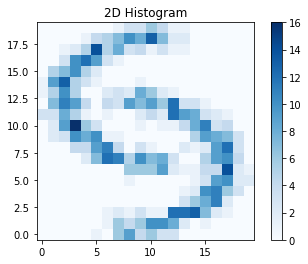

In [6]:
def train_histogram(X, y, bins=20):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_bins = np.linspace(x_min, x_max, bins + 1)
    y_bins = np.linspace(y_min, y_max, bins + 1)
    
    histogram = np.histogram2d(X[:, 0], X[:, 1], bins=[x_bins, y_bins])[0]
    
    return histogram

# Train histogram for a specific dataset (e.g., the small one)
X_small, y_small = datasets["Large"]
histogram_small = train_histogram(X_small, y_small)

# You can visualize the histogram if needed
plt.imshow(histogram_small, origin='lower', cmap='Blues')
plt.colorbar()
plt.title('2D Histogram')
plt.show()

# 2. Higher-dimensional data

## Loading and splitting the data

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Let's load the dataset and split in train and test set and analyze how well the digits are distributed:

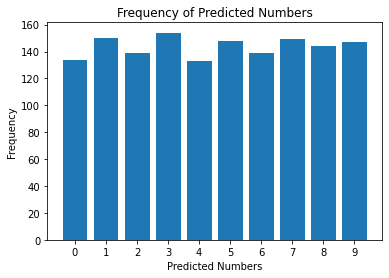

In [10]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_train)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()


We see, that the digits are in evenly distributed frequency in the train dataset

## Define Maximum Mean Discrepancy

In [11]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "rbf" or "inverse-multi-quadratic"
    """
    # Compute squared Euclidean distances

    xx, yy, zz = np.dot(x, x.T), np.dot(y, y.T), np.dot(x, y.T)
    rx = np.diag(xx).reshape(1, -1).repeat(xx.shape[0], axis=0)
    ry = np.diag(yy).reshape(1, -1).repeat(yy.shape[0], axis=0)

    dxx = rx.T + rx - 2. * xx  # Used for A in (1)
    dyy = ry.T + ry - 2. * yy  # Used for B in (1)
    dxy = rx.T + ry - 2. * zz  # Used for C in (1)

    XX, YY, XY = (np.zeros_like(xx), 
                  np.zeros_like(xx), 
                  np.zeros_like(xx))
    
    # Squared Exponential or Gaussian Kernel
    if kernel == "rbf":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(np.exp(-0.5 * dxx / a) for a in bandwidth_range)
        YY = sum(np.exp(-0.5 * dyy / a) for a in bandwidth_range)
        XY = sum(np.exp(-0.5 * dxy / a) for a in bandwidth_range)

    # Inverse Multi-Quadratic Kernel
    if kernel == "inverse-multi-quadratic":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(1 / (dxx / a + 1) for a in bandwidth_range)
        YY = sum(1 / (dyy / a + 1) for a in bandwidth_range)
        XY = sum(1 / (dxy / a + 1) for a in bandwidth_range)

    return np.mean(XX + YY - 2. * XY)

## Density Forest

As a first generative network we try to implement the Density Forest implemtation from https://github.com/kfritsch/density_forest


0.9857876261742521
0.9869981915860978
0.9629515202451933
0.9724714066439486
0.9762483707289074
[2.05270033 1.98594823]
[[ 0.28104953 -0.03427428]
 [-0.03427428  0.76206155]]
[7.92478726 7.99433023]
[[0.98950855 0.07043019]
 [0.07043019 0.45123263]]


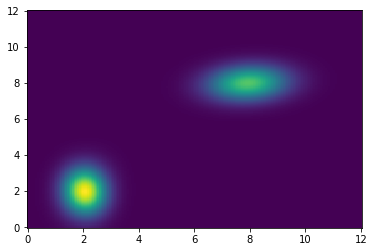

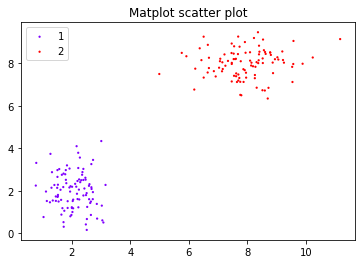

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 64

In [3]:
from DensityForest import DensityForest
X = X_train
density_forest = DensityForest(n_estimators=20)
density_forest.fit(X)


After a few hours of bug fixing in the code, since it had semantic and syntax errors. We are now at a point, were the networks starts training, but we still run into an additional Error in the Node implementation. Since fixing the semantic error of the Node class and potential further errors and a seperate implementation of the sampling method would be over the scope of the first assignment we decided to skip the density forest implementation and will continue with the single gaussian.

## Single Gaussian
Now we implement a single Gaussian model, by using the 'GaussianMixture' model from scikit-learn with just one component

MMD with squared exponential kernel: 0.027863114876388897
MMD with inverse multi quadratic kernel: 0.03015763195614138


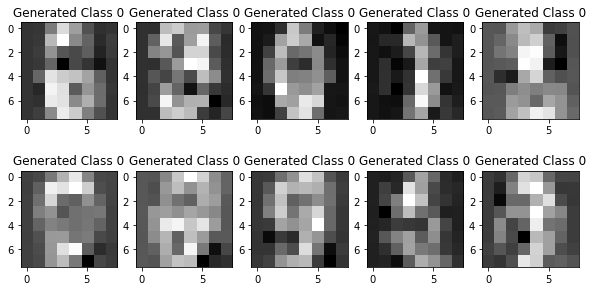

In [30]:
n_components = 1
single_gaussian = GaussianMixture(n_components=n_components)
single_gaussian.fit(X_train)

new_samples, _ = single_gaussian.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

new_samples, _ = single_gaussian.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

We can see that the single Gaussian is already capable of generating number like images, with some samples  indicate legible numbers with higher noise. However, it clearly still lacks the capability to generate decent quality images in the majority of samples. Next, we will analyze the quality of generated dependend on the dataset size

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


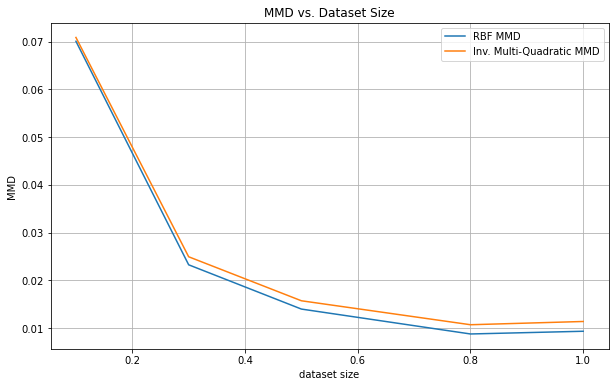

In [36]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_gaussian = []
inv_gaussian = []
var_data_gaussian = GaussianMixture(n_components=1)

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)
    
    # Train the classifier on the current dataset size
    var_data_gaussian.fit(X)
    new_samples, _ = var_data_gaussian.sample(len(X))
    rbf_gaussian.append(MMD(X,new_samples, "rbf"))
    inv_gaussian.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_gaussian, label="RBF MMD")
plt.plot(dataset_sizes, inv_gaussian, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

We see, the model improves the more training data it uses

## Gaussian mixture model (GMM)
Let's continue with training a Gaussian mixture model (GMM) and start by using 50 gaussian components

MMD with squared exponential kernel: 0.027873892208302355
MMD with inverse multi quadratic kernel: 0.028409240039774637


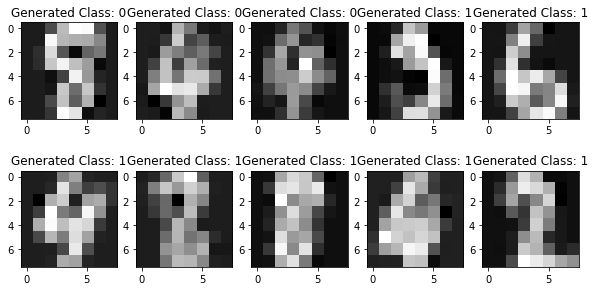

In [31]:
n_components = 55
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_train)
new_samples, _ = gmm.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

# plot generated images
new_samples, _ = gmm.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

Now we investigate the hyperparameter number of components (n_components) in an grid search attempt to find a good fit

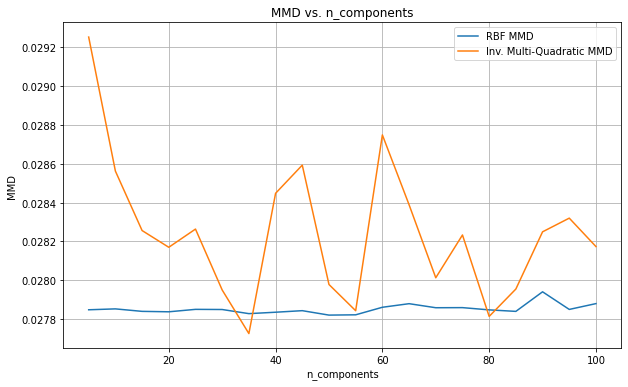

In [26]:
n_components = list(range(5, 101, 5))
rbf_mmd = []
inv_mmd = []
for _, n in enumerate(n_components):
    n_gmm = GaussianMixture(n_components=n)
    n_gmm.fit(X_train)
    new_samples, _ = n_gmm.sample(len(X_test))
    rbf_mmd.append(MMD(X_test,new_samples, "rbf"))
    inv_mmd.append(MMD(X_test,new_samples, "inverse-multi-quadratic"))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_components, rbf_mmd, label="RBF MMD")
plt.plot(n_components, inv_mmd, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. n_components")
plt.xlabel("n_components")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

plt.show()

Furthe we test the influence of the dataset size with the optimal n_component size

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


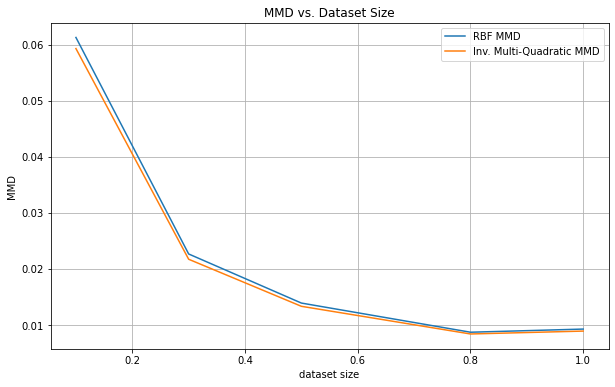

In [37]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_gmm = []
inv_gmm = []
var_data_gmm = GaussianMixture(n_components=55)

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)
    
    # Train the classifier on the current dataset size
    var_data_gmm.fit(X)
    new_samples, _ = var_data_gmm.sample(len(X))
    rbf_gmm.append(MMD(X,new_samples, "rbf"))
    inv_gmm.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_gmm, label="RBF MMD")
plt.plot(dataset_sizes, inv_gmm, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

Also here the model improves with dataset size

## Kernel Density Estimator (KDE)

Now we implement a kernel density estimator (KDE) with squared exponential kernel

MMD with squared exponential kernel: 0.0279159077840152
MMD with inverse multi quadratic kernel: 0.02835229671311289


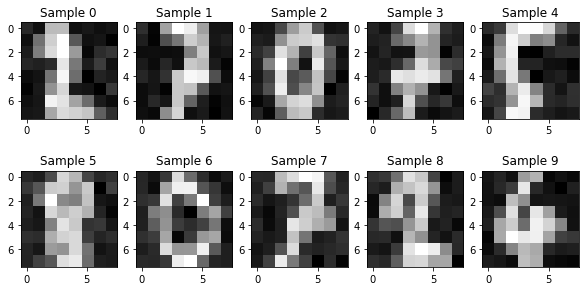

In [27]:
from sklearn.neighbors import KernelDensity
bandwidth = 1.1
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(X_train)
new_samples = kde.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

new_samples = kde.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

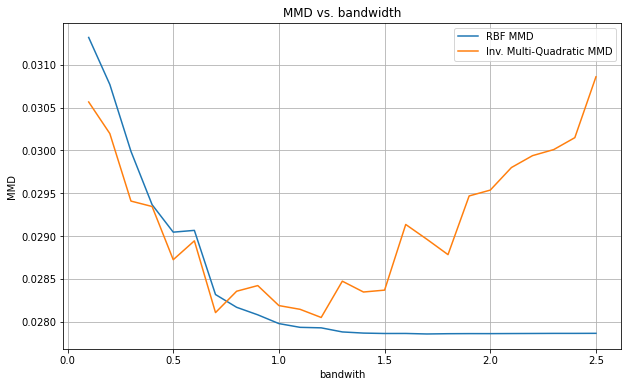

In [18]:
bandwidths = np.arange(0.1, 2.6, 0.1)
rbf_mmd = []
inv_mmd = []
for _, bandwidth in enumerate(bandwidths):
    n_kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    n_kde.fit(X_train)
    new_samples = n_kde.sample(len(X_test))
    rbf_mmd.append(MMD(X_test,new_samples, "rbf"))
    inv_mmd.append(MMD(X_test,new_samples, "inverse-multi-quadratic"))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, rbf_mmd, label="RBF MMD")
plt.plot(bandwidths, inv_mmd, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. bandwidth")
plt.xlabel("bandwith")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

plt.show()

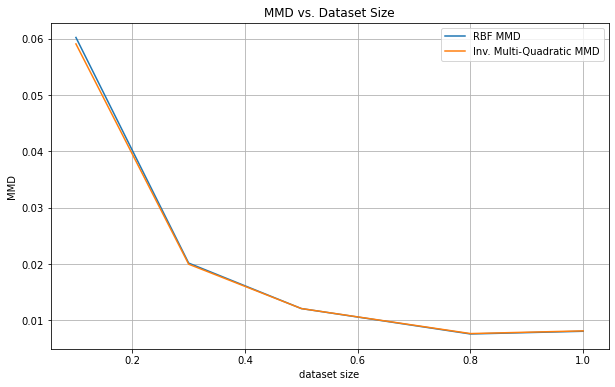

In [38]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_kde = []
inv_kde = []
var_data_gaussian = KernelDensity(bandwidth=1.1, kernel='gaussian')

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)
    
    # Train the classifier on the current dataset size
    var_data_gaussian.fit(X)
    new_samples = var_data_gaussian.sample(len(X))
    rbf_kde.append(MMD(X,new_samples, "rbf"))
    inv_kde.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_kde, label="RBF MMD")
plt.plot(dataset_sizes, inv_kde, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

## Random Forest Classifier
Finally we implement a Random forest classifier on the original dataset to destinguish the 10 digits. Further we will use this classifier to check if the models are working reasonably and that the 10 digits are generated in equal proportion

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on the test data: 0.99


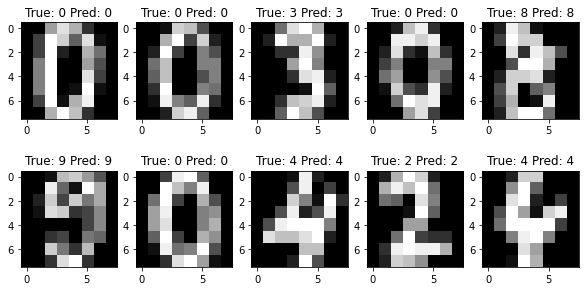

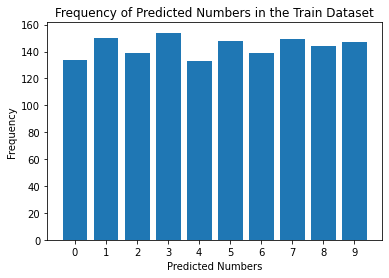

In [20]:
from sklearn.metrics import accuracy_score

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test data: {accuracy:.2f}")
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"True: {y_test[i]} Pred: {y_pred[i]}")
plt.show()

y_pred = rf_classifier.predict(X_train)
# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers in the Train Dataset")
plt.show()

We can see, the Classifier does a really good job on classifying the test dataset. Also the frequency of each predicted class in the training dataset is very evanly spaced out. So now, lets test the classifier on generated data samples from each model!

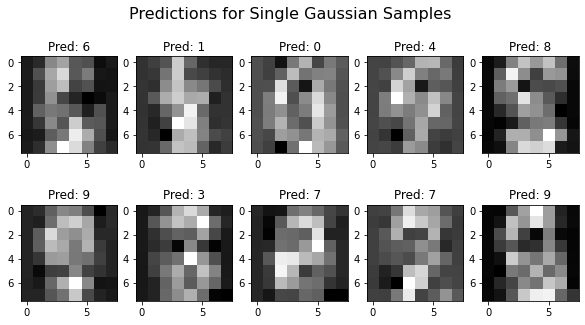

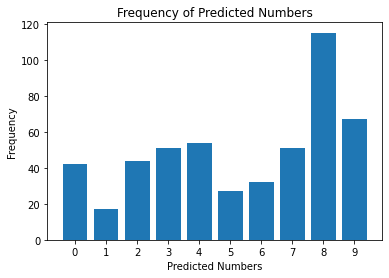

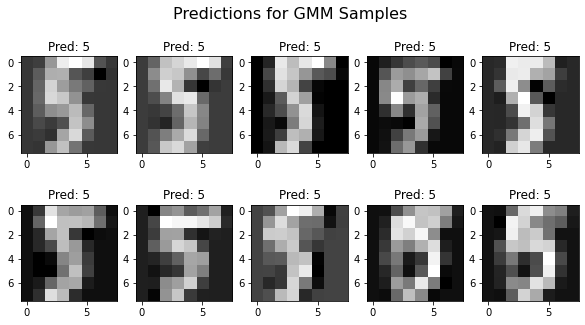

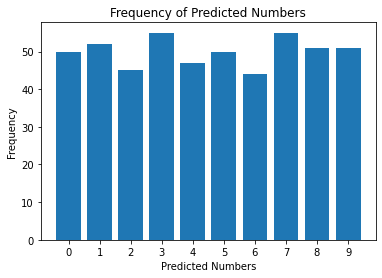

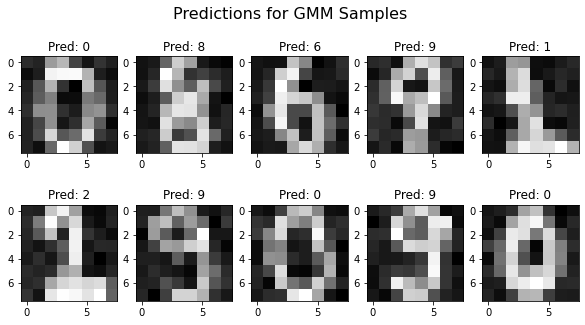

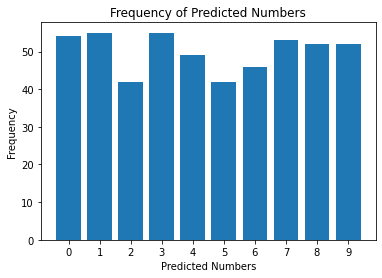

In [28]:
sample_size = 500
samples_gauss, _ = single_gaussian.sample(sample_size)
samples_gmm, _ = gmm.sample(sample_size)
samples_kde = kde.sample(sample_size)


y_pred_gauss = rf_classifier.predict(samples_gauss)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_gauss[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_gauss[i]}")
fig.suptitle("Predictions for Single Gaussian Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_gauss)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

y_pred_gmm = rf_classifier.predict(samples_gmm)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_gmm[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_gmm[i]}")
fig.suptitle("Predictions for GMM Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_gmm)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

y_pred_kde = rf_classifier.predict(samples_kde)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_kde[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_kde[i]}")
fig.suptitle("Predictions for GMM Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_kde)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

From the plot we can see, that the single Gaussian performs the worst on the training dataset since a disproportinal amount of the generated images get classified as the digit 8. The GMM and the KDE both have substentially better results, where the generated images are more evanly classified throuout the classes, suggesting better generated data samples